In [1]:
import pyvinecopulib as pv
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from Ratio import *
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF as fit_ecdf
from scipy.special import logsumexp

def emp_cdf(v, u):
    """ evaluate the empirical copula at points v using the samples u"""
    # cdf is evaluated at points v, v has to be a MxD vector in [0,1]^D, cdf is evaluated at these points
    # u are samples from model NxD vector in [0,1]^D, u should be very large
    # larger u will lead to better estimation of the empirical copula but slows down computation
    cdf_vals = np.empty(shape=(len(v)))
    for i in range(v.shape[0]):
        cdf_vals[i] = np.sum(np.all(u<=v[[i],:], axis=1))
    return cdf_vals/len(u)

In [2]:
def sample(cop_name, nsamples, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    elif cop_name == "mixture":
        combination = params["combination"]
        copulas = [pv.Bicop(family=pv.BicopFamily[comp["type"]], parameters=comp["theta"]) for comp in combination]
        weights = [comp["weight"] for comp in combination]
        copula = pv.MixtureBicop(copulas, weights)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    return copula.simulate(nsamples)

def log_likelihood(cop_name, u1, u2, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    data = np.column_stack((u1, u2))
    return copula.loglik(data)

# Example usage:
params_gaussian = {"corrMatrix": [0.1]}
samples = sample("gaussian", 500, params_gaussian)
u1, u2 = samples[:, 0], samples[:, 1]
log_likelihood_value = log_likelihood("gaussian", u1, u2, params_gaussian)
print(log_likelihood_value)

3.481434546311933


In [3]:
N_TRAIN = 1000
N_TEST = 5000
N_ROUNDS = 25
np.random.seed(990109)

sims_runs_all = []
log_likelihoods_runs_all = []

for round in tqdm(range(N_ROUNDS)):
    # Generate data

    # Student-t
    corrMatrix = np.random.uniform(0.5,0.95)
    nu = np.random.uniform(2,10)

    params_student = {"corrMatrix": corrMatrix, "nu": nu}
    samples_student = sample("student", N_TRAIN + N_TEST, params_student)
    u1_student, u2_student = samples_student[:, 0], samples_student[:, 1]
    log_likelihood_student = log_likelihood("student", u1_student[N_TRAIN:], u2_student[N_TRAIN:], params_student)

    # Clayton
    theta = 2
    params_clayton = {"theta": [theta]}
    samples_clayton = sample("clayton", N_TRAIN + N_TEST, params_clayton)
    u1_clayton, u2_clayton = samples_clayton[:, 0], samples_clayton[:, 1]
    log_likelihood_clayton = log_likelihood("clayton", u1_clayton[N_TRAIN:], u2_clayton[N_TRAIN:], params_clayton)

    # Gumbel
    theta = 2
    params_gumbel = {"theta": [theta]}
    samples_gumbel = sample("gumbel", N_TRAIN + N_TEST, params_gumbel)
    u1_gumbel, u2_gumbel = samples_gumbel[:, 0], samples_gumbel[:, 1]
    log_likelihood_gumbel = log_likelihood("gumbel", u1_gumbel[N_TRAIN:], u2_gumbel[N_TRAIN:], params_gumbel)

    # Mixture of 2 gaussians (using scipy.stats: first mixture on gaussian z-space, then transform to copula u-space)
    '''
    # My mixture 
    means = [[np.random.uniform(-5, 5), np.random.uniform(-5, 5)]for _ in range(2)]
    covs = [np.random.uniform(-0.95, 0.95), np.random.uniform(-0.95, 0.95)]
    multipliers = [np.random.uniform(0.8,1.2), np.random.uniform(0.8,1.2)]
    z = np.concatenate(
        [scs.multivariate_normal.rvs(
        mean=means[i], cov=multipliers[i]*np.array([[1,covs[i]],[covs[i],1]]
        ), size=int((N_TRAIN + N_TEST)/2)) for i in range(2)])
    u_1_mix = 0.5*(scs.norm(loc=means[0][0], scale=multipliers[0]).cdf(z[:,0]) + scs.norm(loc=means[1][0], scale=multipliers[1]).cdf(z[:,0]))
    u_2_mix = 0.5*(scs.norm(loc=means[0][1], scale=multipliers[0]).cdf(z[:,1]) + scs.norm(loc=means[1][1], scale=multipliers[1]).cdf(z[:,1]))
    u_1_mix = u_1_mix[np.random.permutation(N_TRAIN + N_TEST)]
    u_2_mix = u_2_mix[np.random.permutation(N_TRAIN + N_TEST)]
    log_likelihood_top = scs.multivariate_normal.logpdf(z[N_TRAIN:], mean=means[0], cov=multipliers[0]*np.array([[1,covs[0]],[covs[0],1]])).sum() + scs.multivariate_normal.logpdf(z[N_TRAIN:], mean=means[1], cov=multipliers[1]*np.array([[1,covs[1]],[covs[1],1]]).sum()) 
    log_likelihood_bottom = '''
    # ----------------------------- IGC mixture -----------------------------
    mu_1 = np.random.uniform(-5,5,2)
    sigma_1 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)
    
    mu_2 = np.random.uniform(-5,5,2)
    sigma_2 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)

    x1 = np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TRAIN+N_TEST)
    x2 = np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TRAIN+N_TEST)

    X = np.vstack([x1,x2])
    np.random.shuffle(X)
    cdf_1 = fit_ecdf(X[:,0])
    cdf_2 = fit_ecdf(X[:,1])
    U = np.column_stack((cdf_1(X[:,0]), cdf_2(X[:,1])))
    
    X_train = np.vstack([np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TRAIN),
                         np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TRAIN)])
    np.random.shuffle(X_train)
    U_train = np.column_stack([cdf_1(X_train[:,0]), cdf_2(X_train[:,1])])

    X_test = np.vstack([np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TEST),
                        np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TEST)])
    np.random.shuffle(X_test)
    U_test = np.column_stack([cdf_1(X_test[:,0]), cdf_2(X_test[:,1])])
    
    u_1_mix = np.concatenate([U_train[:,0], U_test[:,0]])
    u_2_mix = np.concatenate([U_train[:,1], U_test[:,1]])  
    # ----------------------------- IGC mixture -----------------------------



    # append to list
    sims_runs_all.append([[u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]])
    log_likelihoods_runs_all.append([log_likelihood_student, log_likelihood_clayton, log_likelihood_gumbel, _])

100%|██████████| 25/25 [00:01<00:00, 18.87it/s]


KeyboardInterrupt: 

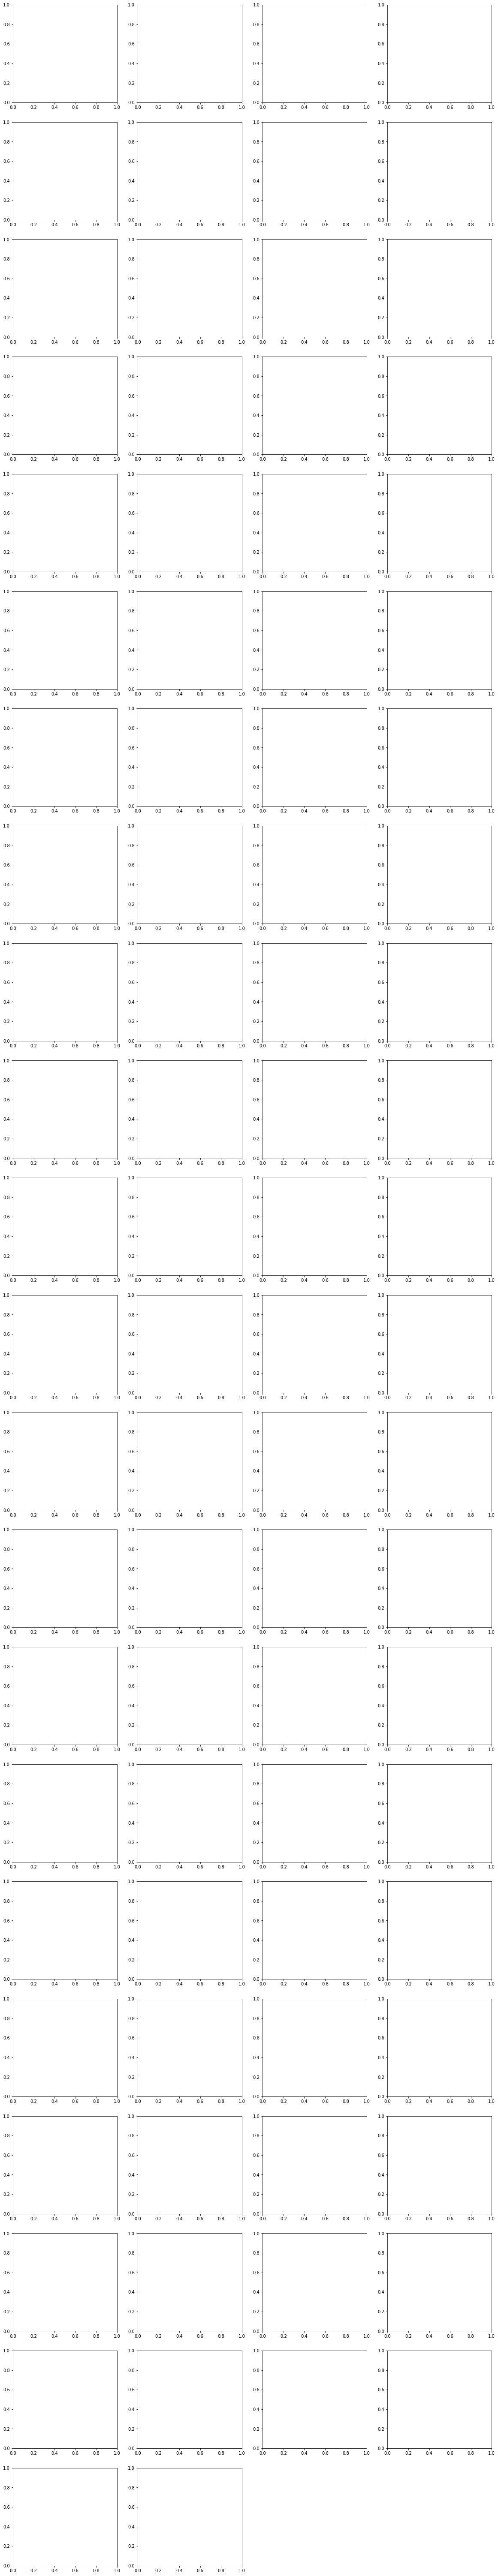

In [4]:
import matplotlib.pyplot as plt

# Assuming sims_runs_all is already populated with the samples

fig, axes = plt.subplots(24, 4, figsize=(20, 120))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

for i in range(24):
    for j in range(4):
        ax = axes[i * 4 + j]
        u1, u2 = sims_runs_all[i][j]
        ax.scatter(u1, u2, s=1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'Round {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

In [27]:
ratios = []

for r,run in tqdm(enumerate(sims_runs_all)):
    # run = [u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]
    for u,u1_u2 in enumerate(run):
        # u1_u2 = [u1, u2]
        z1,z2 = scs.norm.ppf(u1_u2[0][:N_TRAIN]),scs.norm.ppf(u1_u2[1][:N_TRAIN])
        p_data = np.column_stack((z1,z2))
        p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
        q_data = np.random.randn(50000,2)
        # Fit Ratio copula
        ratio = Ratio(h_dim=100, in_dim=2, h_layers=2, normalising_cst=True)
        #optimizer = torch.optim.Adam(ratio.parameters())
        optimizer = torch.optim.Adam(
            [{'params': [param for param in ratio.parameters() if param is not ratio.c]},
            {'params': [ratio.c], 'lr': 0.001}]  # Adjust the learning rate for ratio.c here
        )
        #if ratio.normalising_cst:
        #    optimizer.add_param_group({'params': ratio.c})

        for epoch in (range(501)):
            optimizer.zero_grad()
            r_p = ratio(torch.tensor(p_data).float())
            r_q = ratio(torch.tensor(np.random.randn(p_data.shape[0],2)).float())
            #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
            loss = loss_nce(r_p, r_q, p_data.shape[0], q_data.shape[0])
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0 and epoch > 0:
                with torch.no_grad():
                    if True:#epoch==500:# check the value and gradient of the normalising constant
                        print(f'Epoch {epoch}, normalising constant {ratio.c.item()}', ratio.c.grad.item())
                    #check if loss is not a number
                    if torch.isnan(loss):
                        print(r,u,'NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                    #print(f'Epoch {epoch}, loss {loss.item()}')
        print('run',r,'cop_u',u,'DONE')
        ratios.append(ratio)


0it [00:00, ?it/s]

Epoch 100, normalising constant 1.015202283859253 -0.03247249126434326
Epoch 200, normalising constant 1.0140682458877563 0.14002734422683716
Epoch 300, normalising constant 1.012495756149292 0.02781510353088379
Epoch 400, normalising constant 1.010737657546997 0.05744123458862305
Epoch 500, normalising constant 1.0095185041427612 -0.03357428312301636
run 0 cop_u 0 DONE
Epoch 100, normalising constant 1.009556770324707 0.0004583001136779785
Epoch 200, normalising constant 1.0080398321151733 -0.045768916606903076
Epoch 300, normalising constant 1.0069869756698608 0.01647770404815674
Epoch 400, normalising constant 1.0074676275253296 0.07729929685592651
Epoch 500, normalising constant 1.0056495666503906 -0.02178555727005005
run 0 cop_u 1 DONE
Epoch 100, normalising constant 0.9993813037872314 0.13483256101608276
Epoch 200, normalising constant 0.9967413544654846 0.025011003017425537
Epoch 300, normalising constant 0.9949718117713928 -0.04352444410324097
Epoch 400, normalising constant 0.

1it [00:14, 14.26s/it]

Epoch 500, normalising constant 0.9992650747299194 0.04185217618942261
run 0 cop_u 3 DONE
Epoch 100, normalising constant 1.001837968826294 0.01135343313217163
Epoch 200, normalising constant 1.001923680305481 0.04275542497634888
Epoch 300, normalising constant 1.0013033151626587 0.07937318086624146
Epoch 400, normalising constant 0.9999580979347229 -0.05270099639892578
Epoch 500, normalising constant 0.9988573789596558 0.03785276412963867
run 1 cop_u 0 DONE
Epoch 100, normalising constant 1.0046192407608032 0.032292842864990234
Epoch 200, normalising constant 1.0025441646575928 -0.07624471187591553
Epoch 300, normalising constant 1.0020043849945068 -0.08930462598800659
Epoch 400, normalising constant 1.0020973682403564 0.019256591796875
Epoch 500, normalising constant 1.0021989345550537 0.06183338165283203
run 1 cop_u 1 DONE
Epoch 100, normalising constant 1.0101319551467896 0.006101429462432861
Epoch 200, normalising constant 1.0074363946914673 0.014007270336151123
Epoch 300, normali

2it [00:28, 14.26s/it]

Epoch 500, normalising constant 0.9977825880050659 0.0382457971572876
run 1 cop_u 3 DONE
Epoch 100, normalising constant 1.0045850276947021 0.05538344383239746
Epoch 200, normalising constant 1.004377007484436 -0.06316065788269043
Epoch 300, normalising constant 1.0040181875228882 -0.027916550636291504
Epoch 400, normalising constant 1.0036447048187256 -0.021520674228668213
Epoch 500, normalising constant 1.0032062530517578 -0.2641069293022156
run 2 cop_u 0 DONE
Epoch 100, normalising constant 1.0030182600021362 -0.06336289644241333
Epoch 200, normalising constant 1.0042296648025513 0.00821918249130249
Epoch 300, normalising constant 1.004713773727417 0.033786654472351074
Epoch 400, normalising constant 1.0046889781951904 -0.0045340657234191895
Epoch 500, normalising constant 1.0049046277999878 -0.03439366817474365
run 2 cop_u 1 DONE
Epoch 100, normalising constant 1.022406816482544 0.030608654022216797
Epoch 200, normalising constant 1.0225356817245483 -0.005223870277404785
Epoch 300,

3it [00:42, 14.35s/it]

Epoch 500, normalising constant 1.0072133541107178 -0.06606453657150269
run 2 cop_u 3 DONE
Epoch 100, normalising constant 1.0067715644836426 -0.014503300189971924
Epoch 200, normalising constant 1.005583643913269 0.06385958194732666
Epoch 300, normalising constant 1.0029960870742798 -0.04633140563964844
Epoch 400, normalising constant 1.002071499824524 0.04196900129318237
Epoch 500, normalising constant 1.0000020265579224 0.03593790531158447
run 3 cop_u 0 DONE
Epoch 100, normalising constant 1.0066146850585938 -0.010742485523223877
Epoch 200, normalising constant 1.006325125694275 0.01366037130355835
Epoch 300, normalising constant 1.0056209564208984 -0.005568146705627441
Epoch 400, normalising constant 1.0050110816955566 -0.08290553092956543
Epoch 500, normalising constant 1.0057133436203003 0.07251644134521484
run 3 cop_u 1 DONE
Epoch 100, normalising constant 1.0144367218017578 -0.05946296453475952
Epoch 200, normalising constant 1.0142608880996704 -0.025363683700561523
Epoch 300, 

4it [00:57, 14.45s/it]

Epoch 500, normalising constant 1.0045967102050781 -0.02663189172744751
run 3 cop_u 3 DONE
Epoch 100, normalising constant 1.0185575485229492 0.19539779424667358
Epoch 200, normalising constant 1.0176081657409668 -0.08660030364990234
Epoch 300, normalising constant 1.0171430110931396 -0.07868528366088867
Epoch 400, normalising constant 1.0166536569595337 0.04644829034805298
Epoch 500, normalising constant 1.0165596008300781 -0.09124237298965454
run 4 cop_u 0 DONE
Epoch 100, normalising constant 1.011532187461853 -0.03875744342803955
Epoch 200, normalising constant 1.0095258951187134 -0.15690851211547852
Epoch 300, normalising constant 1.009698510169983 -0.09724801778793335
Epoch 400, normalising constant 1.010290265083313 0.032691240310668945
Epoch 500, normalising constant 1.0089712142944336 -0.017574667930603027
run 4 cop_u 1 DONE
Epoch 100, normalising constant 0.9997661709785461 -0.06909191608428955
Epoch 200, normalising constant 0.9985067248344421 -0.018419623374938965
Epoch 300,

5it [01:13, 14.96s/it]

Epoch 500, normalising constant 1.0048588514328003 -0.027796804904937744
run 4 cop_u 3 DONE
Epoch 100, normalising constant 1.012432336807251 0.027548015117645264
Epoch 200, normalising constant 1.01028573513031 -0.09515213966369629
Epoch 300, normalising constant 1.0105504989624023 -0.07187050580978394
Epoch 400, normalising constant 1.0107890367507935 0.008571922779083252
Epoch 500, normalising constant 1.0096207857131958 -0.13326716423034668
run 5 cop_u 0 DONE
Epoch 100, normalising constant 0.9991787075996399 -0.10893148183822632
Epoch 200, normalising constant 0.9997609257698059 0.0066048502922058105
Epoch 300, normalising constant 1.0000885725021362 -0.050045669078826904
Epoch 400, normalising constant 1.00048828125 0.13424086570739746
Epoch 500, normalising constant 1.0003474950790405 -0.1145368218421936
run 5 cop_u 1 DONE
Epoch 100, normalising constant 1.0038704872131348 -0.05825263261795044
Epoch 200, normalising constant 1.0028249025344849 -0.0205652117729187
Epoch 300, norm

6it [01:28, 15.09s/it]

Epoch 500, normalising constant 1.0022650957107544 -0.10402452945709229
run 5 cop_u 3 DONE
Epoch 100, normalising constant 1.0015580654144287 -0.006196439266204834
Epoch 200, normalising constant 1.0002217292785645 -0.02165830135345459
Epoch 300, normalising constant 0.9997718930244446 -0.017678499221801758
Epoch 400, normalising constant 0.9987059235572815 0.05501997470855713
Epoch 500, normalising constant 0.9976845979690552 0.05873250961303711
run 6 cop_u 0 DONE
Epoch 100, normalising constant 1.0070315599441528 0.10796940326690674
Epoch 200, normalising constant 1.0075271129608154 -0.024602830410003662
Epoch 300, normalising constant 1.0081572532653809 -0.11442369222640991
Epoch 400, normalising constant 1.0098446607589722 0.0126456618309021
Epoch 500, normalising constant 1.011051058769226 0.019407987594604492
run 6 cop_u 1 DONE
Epoch 100, normalising constant 0.9970360398292542 0.0628507137298584
Epoch 200, normalising constant 0.9967681169509888 0.044286906719207764
Epoch 300, n

7it [01:43, 15.12s/it]

Epoch 500, normalising constant 1.0006651878356934 -0.030152738094329834
run 6 cop_u 3 DONE
Epoch 100, normalising constant 0.9973987936973572 0.07383602857589722
Epoch 200, normalising constant 0.9962102174758911 -0.11215287446975708
Epoch 300, normalising constant 0.9962128400802612 0.05063897371292114
Epoch 400, normalising constant 0.9962419271469116 -0.059947073459625244
Epoch 500, normalising constant 0.9953046441078186 -0.08001863956451416
run 7 cop_u 0 DONE
Epoch 100, normalising constant 1.0029689073562622 -0.012090206146240234
Epoch 200, normalising constant 1.0014067888259888 -0.00014251470565795898
Epoch 300, normalising constant 1.0019011497497559 0.013693690299987793
Epoch 400, normalising constant 1.0014528036117554 -0.027955830097198486
Epoch 500, normalising constant 1.0019885301589966 0.045304834842681885
run 7 cop_u 1 DONE
Epoch 100, normalising constant 0.9970468878746033 0.008693158626556396
Epoch 200, normalising constant 0.9956631064414978 0.0673302412033081
Epoc

8it [01:59, 15.37s/it]

Epoch 500, normalising constant 1.003076434135437 -0.027669668197631836
run 7 cop_u 3 DONE
Epoch 100, normalising constant 0.9998342990875244 0.04239225387573242
Epoch 200, normalising constant 0.9975491166114807 0.03948420286178589
Epoch 300, normalising constant 0.9953153133392334 0.03797173500061035
Epoch 400, normalising constant 0.9933131337165833 0.020463943481445312
Epoch 500, normalising constant 0.9912395477294922 0.0043141841888427734
run 8 cop_u 0 DONE
Epoch 100, normalising constant 1.0084360837936401 -0.07271522283554077
Epoch 200, normalising constant 1.0083056688308716 -0.06839680671691895
Epoch 300, normalising constant 1.0077526569366455 -0.04958385229110718
Epoch 400, normalising constant 1.0082124471664429 0.1294238567352295
Epoch 500, normalising constant 1.0072472095489502 -0.02282559871673584
run 8 cop_u 1 DONE
Epoch 100, normalising constant 1.0137771368026733 0.011175811290740967
Epoch 200, normalising constant 1.0115879774093628 -0.013934493064880371
Epoch 300,

9it [02:15, 15.46s/it]

Epoch 500, normalising constant 0.993313193321228 -0.0026253461837768555
run 8 cop_u 3 DONE
Epoch 100, normalising constant 1.002005934715271 0.09861910343170166
Epoch 200, normalising constant 1.0003268718719482 -0.0434839129447937
Epoch 300, normalising constant 0.9972293376922607 -0.05716729164123535
Epoch 400, normalising constant 0.9950641393661499 -0.0006972551345825195
Epoch 500, normalising constant 0.9933043122291565 0.03856348991394043
run 9 cop_u 0 DONE
Epoch 100, normalising constant 1.0043748617172241 -0.03545498847961426
Epoch 200, normalising constant 1.004596471786499 0.03487032651901245
Epoch 300, normalising constant 1.0031445026397705 0.060022592544555664
Epoch 400, normalising constant 1.001716136932373 -0.015548884868621826
Epoch 500, normalising constant 1.001366376876831 -0.01897406578063965
run 9 cop_u 1 DONE
Epoch 100, normalising constant 1.0172358751296997 -0.060756683349609375
Epoch 200, normalising constant 1.0155048370361328 0.03725022077560425
Epoch 300, 

10it [02:31, 15.51s/it]

Epoch 500, normalising constant 1.0036824941635132 -0.16407060623168945
run 9 cop_u 3 DONE
Epoch 100, normalising constant 0.9999542236328125 0.013815224170684814
Epoch 200, normalising constant 0.9996758103370667 0.023194432258605957
Epoch 300, normalising constant 0.9990079998970032 -0.0010228753089904785
Epoch 400, normalising constant 0.9985028505325317 -0.011805236339569092
Epoch 500, normalising constant 0.9975073337554932 0.017303764820098877
run 10 cop_u 0 DONE
Epoch 100, normalising constant 1.0114072561264038 0.09856057167053223
Epoch 200, normalising constant 1.0100605487823486 -0.016372621059417725
Epoch 300, normalising constant 1.0084973573684692 0.01328897476196289
Epoch 400, normalising constant 1.0067039728164673 -0.07945096492767334
Epoch 500, normalising constant 1.006502628326416 0.05069446563720703
run 10 cop_u 1 DONE
Epoch 100, normalising constant 1.0074495077133179 -0.03147292137145996
Epoch 200, normalising constant 1.0082544088363647 -0.001105666160583496
Epoc

11it [02:46, 15.60s/it]

Epoch 500, normalising constant 1.0097748041152954 -0.02370595932006836
run 10 cop_u 3 DONE
Epoch 100, normalising constant 0.9984058141708374 0.018630146980285645
Epoch 200, normalising constant 0.998228907585144 -0.0029630064964294434
Epoch 300, normalising constant 0.9974434971809387 -0.03669178485870361
Epoch 400, normalising constant 0.9962992668151855 -0.09901362657546997
Epoch 500, normalising constant 0.9973177313804626 0.10622942447662354
run 11 cop_u 0 DONE
Epoch 100, normalising constant 0.9959043860435486 -0.02833491563796997
Epoch 200, normalising constant 0.9950342178344727 0.008282065391540527
Epoch 300, normalising constant 0.9938914179801941 0.0848318338394165
Epoch 400, normalising constant 0.9933896064758301 0.0006958842277526855
Epoch 500, normalising constant 0.9924465417861938 0.019314885139465332
run 11 cop_u 1 DONE
Epoch 100, normalising constant 0.9970491528511047 -0.030184388160705566
Epoch 200, normalising constant 0.9976340532302856 0.1264026165008545
Epoch 

12it [03:03, 15.78s/it]

Epoch 500, normalising constant 1.0074604749679565 -0.005284368991851807
run 11 cop_u 3 DONE
Epoch 100, normalising constant 1.0123671293258667 0.04591560363769531
Epoch 200, normalising constant 1.0125027894973755 -0.10789668560028076
Epoch 300, normalising constant 1.0121101140975952 -0.016859352588653564
Epoch 400, normalising constant 1.0124825239181519 -0.023844480514526367
Epoch 500, normalising constant 1.0115457773208618 -0.02496117353439331
run 12 cop_u 0 DONE
Epoch 100, normalising constant 0.9996209144592285 0.05350548028945923
Epoch 200, normalising constant 0.9987829923629761 0.045549213886260986
Epoch 300, normalising constant 0.996351957321167 -0.04079717397689819
Epoch 400, normalising constant 0.995716392993927 0.0029526352882385254
Epoch 500, normalising constant 0.9954283237457275 0.0020762085914611816
run 12 cop_u 1 DONE
Epoch 100, normalising constant 1.0165334939956665 0.0427280068397522
Epoch 200, normalising constant 1.0158162117004395 -0.018530547618865967
Epoc

13it [03:19, 15.84s/it]

Epoch 500, normalising constant 1.0028088092803955 -0.020860671997070312
run 12 cop_u 3 DONE
Epoch 100, normalising constant 1.0034217834472656 0.049151062965393066
Epoch 200, normalising constant 1.00338613986969 0.063518226146698
Epoch 300, normalising constant 1.0025506019592285 0.04195600748062134
Epoch 400, normalising constant 1.000603437423706 -0.005162954330444336
Epoch 500, normalising constant 0.9984261393547058 -0.10601192712783813
run 13 cop_u 0 DONE
Epoch 100, normalising constant 1.0004007816314697 -0.08006387948989868
Epoch 200, normalising constant 0.9992080330848694 0.023498594760894775
Epoch 300, normalising constant 0.99887615442276 0.020248770713806152
Epoch 400, normalising constant 0.9984942078590393 0.0781664252281189
Epoch 500, normalising constant 0.9983428716659546 -0.015830576419830322
run 13 cop_u 1 DONE
Epoch 100, normalising constant 0.9990249276161194 -0.014528393745422363
Epoch 200, normalising constant 0.9975177049636841 0.09433084726333618
Epoch 300, n

14it [03:34, 15.80s/it]

Epoch 500, normalising constant 0.9910843372344971 0.07200843095779419
run 13 cop_u 3 DONE
Epoch 100, normalising constant 1.0129520893096924 -0.046228885650634766
Epoch 200, normalising constant 1.0123370885849 -0.03320109844207764
Epoch 300, normalising constant 1.0125105381011963 -0.11428689956665039
Epoch 400, normalising constant 1.0122007131576538 -0.062165677547454834
Epoch 500, normalising constant 1.0132895708084106 -0.009316861629486084
run 14 cop_u 0 DONE
Epoch 100, normalising constant 1.018216609954834 0.00838625431060791
Epoch 200, normalising constant 1.0181947946548462 0.03558129072189331
Epoch 300, normalising constant 1.0171833038330078 0.004747629165649414
Epoch 400, normalising constant 1.0170925855636597 0.1638261079788208
Epoch 500, normalising constant 1.0155580043792725 0.053060948848724365
run 14 cop_u 1 DONE
Epoch 100, normalising constant 1.0157910585403442 -0.09214913845062256
Epoch 200, normalising constant 1.0148851871490479 -0.08119726181030273
Epoch 300,

15it [03:50, 15.78s/it]

Epoch 500, normalising constant 1.0019639730453491 0.03696507215499878
run 14 cop_u 3 DONE
Epoch 100, normalising constant 1.000046968460083 -0.022148728370666504
Epoch 200, normalising constant 0.9960657954216003 -0.016362369060516357
Epoch 300, normalising constant 0.9926009774208069 -0.034975409507751465
Epoch 400, normalising constant 0.9901411533355713 -0.02395719289779663
Epoch 500, normalising constant 0.9875089526176453 0.03190183639526367
run 15 cop_u 0 DONE
Epoch 100, normalising constant 1.0193837881088257 0.025999009609222412
Epoch 200, normalising constant 1.0191481113433838 -0.07287877798080444
Epoch 300, normalising constant 1.0195927619934082 -0.0016803145408630371
Epoch 400, normalising constant 1.0189920663833618 -0.016812264919281006
Epoch 500, normalising constant 1.0189851522445679 -0.025987744331359863
run 15 cop_u 1 DONE
Epoch 100, normalising constant 1.012075662612915 -0.021851956844329834
Epoch 200, normalising constant 1.011775255203247 -0.020941197872161865


16it [04:08, 16.37s/it]

Epoch 500, normalising constant 0.9947203993797302 0.02485603094100952
run 15 cop_u 3 DONE
Epoch 100, normalising constant 1.010633945465088 -0.014044106006622314
Epoch 200, normalising constant 1.0115708112716675 -0.03003549575805664
Epoch 300, normalising constant 1.0118752717971802 0.041711270809173584
Epoch 400, normalising constant 1.0125670433044434 0.0655522346496582
Epoch 500, normalising constant 1.0123168230056763 -0.019640445709228516
run 16 cop_u 0 DONE
Epoch 100, normalising constant 0.9964286088943481 -0.016192913055419922
Epoch 200, normalising constant 0.9965633749961853 -0.014089643955230713
Epoch 300, normalising constant 0.9962315559387207 0.013028502464294434
Epoch 400, normalising constant 0.9966937303543091 0.1245567798614502
Epoch 500, normalising constant 0.9961015582084656 -0.018959343433380127
run 16 cop_u 1 DONE
Epoch 100, normalising constant 0.9987999200820923 -0.06806671619415283
Epoch 200, normalising constant 0.9982543587684631 -0.021519839763641357
Epoc

17it [04:24, 16.32s/it]

Epoch 500, normalising constant 1.000192642211914 0.11554622650146484
run 16 cop_u 3 DONE
Epoch 100, normalising constant 1.0001239776611328 -0.042910099029541016
Epoch 200, normalising constant 0.9983992576599121 0.13812875747680664
Epoch 300, normalising constant 0.997636616230011 0.036393702030181885
Epoch 400, normalising constant 0.995397686958313 0.043121159076690674
Epoch 500, normalising constant 0.994426429271698 0.02639937400817871
run 17 cop_u 0 DONE
Epoch 100, normalising constant 1.0107380151748657 -0.04592853784561157
Epoch 200, normalising constant 1.0102401971817017 0.011501133441925049
Epoch 300, normalising constant 1.0099700689315796 -0.003811776638031006
Epoch 400, normalising constant 1.0101901292800903 0.0345417857170105
Epoch 500, normalising constant 1.0100938081741333 -0.0222623348236084
run 17 cop_u 1 DONE
Epoch 100, normalising constant 1.0028626918792725 -0.0054389238357543945
Epoch 200, normalising constant 1.0016019344329834 0.019418776035308838
Epoch 300,

18it [04:40, 16.14s/it]

Epoch 500, normalising constant 0.9971942901611328 -0.04163628816604614
run 17 cop_u 3 DONE
Epoch 100, normalising constant 1.0181852579116821 0.07651054859161377
Epoch 200, normalising constant 1.0170632600784302 0.05375540256500244
Epoch 300, normalising constant 1.0151193141937256 0.030196785926818848
Epoch 400, normalising constant 1.0124015808105469 0.09759539365768433
Epoch 500, normalising constant 1.0103747844696045 0.05993211269378662
run 18 cop_u 0 DONE
Epoch 100, normalising constant 1.0137999057769775 -0.03821283578872681
Epoch 200, normalising constant 1.013658881187439 -0.04634296894073486
Epoch 300, normalising constant 1.014585018157959 0.10720443725585938
Epoch 400, normalising constant 1.0133320093154907 0.027694284915924072
Epoch 500, normalising constant 1.0134608745574951 0.05204164981842041
run 18 cop_u 1 DONE
Epoch 100, normalising constant 1.0038697719573975 0.03329342603683472
Epoch 200, normalising constant 1.0030862092971802 -0.02740257978439331
Epoch 300, no

19it [04:57, 16.56s/it]

Epoch 500, normalising constant 1.0004900693893433 0.0018351078033447266
run 18 cop_u 3 DONE
Epoch 100, normalising constant 1.004228949546814 -0.0011740922927856445
Epoch 200, normalising constant 1.002610206604004 -0.06717121601104736
Epoch 300, normalising constant 1.001106858253479 -0.08533865213394165
Epoch 400, normalising constant 0.9997982978820801 -0.00923764705657959
Epoch 500, normalising constant 0.9986336827278137 0.006538808345794678
run 19 cop_u 0 DONE
Epoch 100, normalising constant 1.0057262182235718 -0.03503936529159546
Epoch 200, normalising constant 1.0051733255386353 0.05915921926498413
Epoch 300, normalising constant 1.0047879219055176 0.03480428457260132
Epoch 400, normalising constant 1.0031847953796387 -0.032274842262268066
Epoch 500, normalising constant 1.0031774044036865 0.022806286811828613
run 19 cop_u 1 DONE
Epoch 100, normalising constant 1.0077381134033203 -0.07693207263946533
Epoch 200, normalising constant 1.0066194534301758 -0.044197797775268555
Epoc

20it [05:15, 17.02s/it]

Epoch 500, normalising constant 1.0213874578475952 -0.023324191570281982
run 19 cop_u 3 DONE
Epoch 100, normalising constant 1.0196717977523804 -0.006259918212890625
Epoch 200, normalising constant 1.0190486907958984 -0.04309892654418945
Epoch 300, normalising constant 1.0187424421310425 -0.05989348888397217
Epoch 400, normalising constant 1.0182775259017944 0.056936442852020264
Epoch 500, normalising constant 1.0168136358261108 -0.1627550721168518
run 20 cop_u 0 DONE
Epoch 100, normalising constant 1.0059762001037598 0.09438782930374146
Epoch 200, normalising constant 1.0050665140151978 -0.11084669828414917
Epoch 300, normalising constant 1.0046322345733643 -0.11688441038131714
Epoch 400, normalising constant 1.003796935081482 0.008327066898345947
Epoch 500, normalising constant 1.0027214288711548 -0.0718843936920166
run 20 cop_u 1 DONE
Epoch 100, normalising constant 1.000985026359558 -0.0608600378036499
Epoch 200, normalising constant 0.9998127818107605 -0.015944361686706543
Epoch 3

21it [05:33, 17.17s/it]

Epoch 500, normalising constant 1.001965880393982 -0.031536757946014404
run 20 cop_u 3 DONE
Epoch 100, normalising constant 1.010689377784729 0.07846581935882568
Epoch 200, normalising constant 1.0104424953460693 -0.2189139723777771
Epoch 300, normalising constant 1.011422038078308 -0.0010824799537658691
Epoch 400, normalising constant 1.0107964277267456 0.01270526647567749
Epoch 500, normalising constant 1.010459542274475 0.15456300973892212
run 21 cop_u 0 DONE
Epoch 100, normalising constant 0.9992489814758301 0.0263139009475708
Epoch 200, normalising constant 0.9981116652488708 0.08627581596374512
Epoch 300, normalising constant 0.997005045413971 0.018760979175567627
Epoch 400, normalising constant 0.9958944916725159 -0.05442279577255249
Epoch 500, normalising constant 0.9957253932952881 -0.047586798667907715
run 21 cop_u 1 DONE
Epoch 100, normalising constant 1.007572054862976 0.08261626958847046
Epoch 200, normalising constant 1.0042136907577515 -0.03844934701919556
Epoch 300, nor

22it [05:49, 16.80s/it]

Epoch 500, normalising constant 0.9873448610305786 0.07304179668426514
run 21 cop_u 3 DONE
Epoch 100, normalising constant 1.0085304975509644 -0.046160340309143066
Epoch 200, normalising constant 1.0028660297393799 0.01672583818435669
Epoch 300, normalising constant 0.9999068975448608 -0.0035572052001953125
Epoch 400, normalising constant 0.996647298336029 0.015940845012664795
Epoch 500, normalising constant 0.9949193596839905 -0.023936867713928223
run 22 cop_u 0 DONE
Epoch 100, normalising constant 1.0059150457382202 0.05571615695953369
Epoch 200, normalising constant 1.004686713218689 0.05797821283340454
Epoch 300, normalising constant 1.0030804872512817 0.09850859642028809
Epoch 400, normalising constant 1.0026423931121826 -0.05313938856124878
Epoch 500, normalising constant 1.0017145872116089 0.08612769842147827
run 22 cop_u 1 DONE
Epoch 100, normalising constant 1.0086603164672852 -0.030656039714813232
Epoch 200, normalising constant 1.0071486234664917 -0.055717527866363525
Epoch 

23it [06:07, 17.07s/it]

Epoch 500, normalising constant 1.0134333372116089 0.044547080993652344
run 22 cop_u 3 DONE
Epoch 100, normalising constant 1.0037784576416016 -0.07553815841674805
Epoch 200, normalising constant 1.0026671886444092 -0.12667489051818848
Epoch 300, normalising constant 1.0015894174575806 -0.11933034658432007
Epoch 400, normalising constant 0.9997885823249817 -0.10042738914489746
Epoch 500, normalising constant 0.9993321895599365 0.1103333830833435
run 23 cop_u 0 DONE
Epoch 100, normalising constant 0.9951465129852295 -0.1413121223449707
Epoch 200, normalising constant 0.9958633780479431 -0.06193423271179199
Epoch 300, normalising constant 0.9958791732788086 0.005279481410980225
Epoch 400, normalising constant 0.9948616027832031 -0.10335588455200195
Epoch 500, normalising constant 0.99603670835495 0.06432265043258667
run 23 cop_u 1 DONE
Epoch 100, normalising constant 1.011112093925476 0.012100160121917725
Epoch 200, normalising constant 1.012372374534607 -0.0026453137397766113
Epoch 300,

24it [06:25, 17.43s/it]

Epoch 500, normalising constant 1.0058393478393555 -0.013784825801849365
run 23 cop_u 3 DONE
Epoch 100, normalising constant 1.0114091634750366 0.027085721492767334
Epoch 200, normalising constant 1.0099711418151855 0.029489576816558838
Epoch 300, normalising constant 1.0084607601165771 0.06691288948059082
Epoch 400, normalising constant 1.006718635559082 -0.05010044574737549
Epoch 500, normalising constant 1.004645586013794 -0.09048539400100708
run 24 cop_u 0 DONE
Epoch 100, normalising constant 1.0038491487503052 0.0007320642471313477
Epoch 200, normalising constant 1.0014888048171997 -0.025884151458740234
Epoch 300, normalising constant 1.0005128383636475 -0.030912041664123535
Epoch 400, normalising constant 0.9991189241409302 -0.1062248945236206
Epoch 500, normalising constant 0.9989773035049438 0.03442031145095825
run 24 cop_u 1 DONE
Epoch 100, normalising constant 0.9979269504547119 0.0030218958854675293
Epoch 200, normalising constant 0.9981491565704346 0.04909020662307739
Epoch

25it [06:43, 16.14s/it]

Epoch 500, normalising constant 1.000673532485962 0.0415266752243042
run 24 cop_u 3 DONE


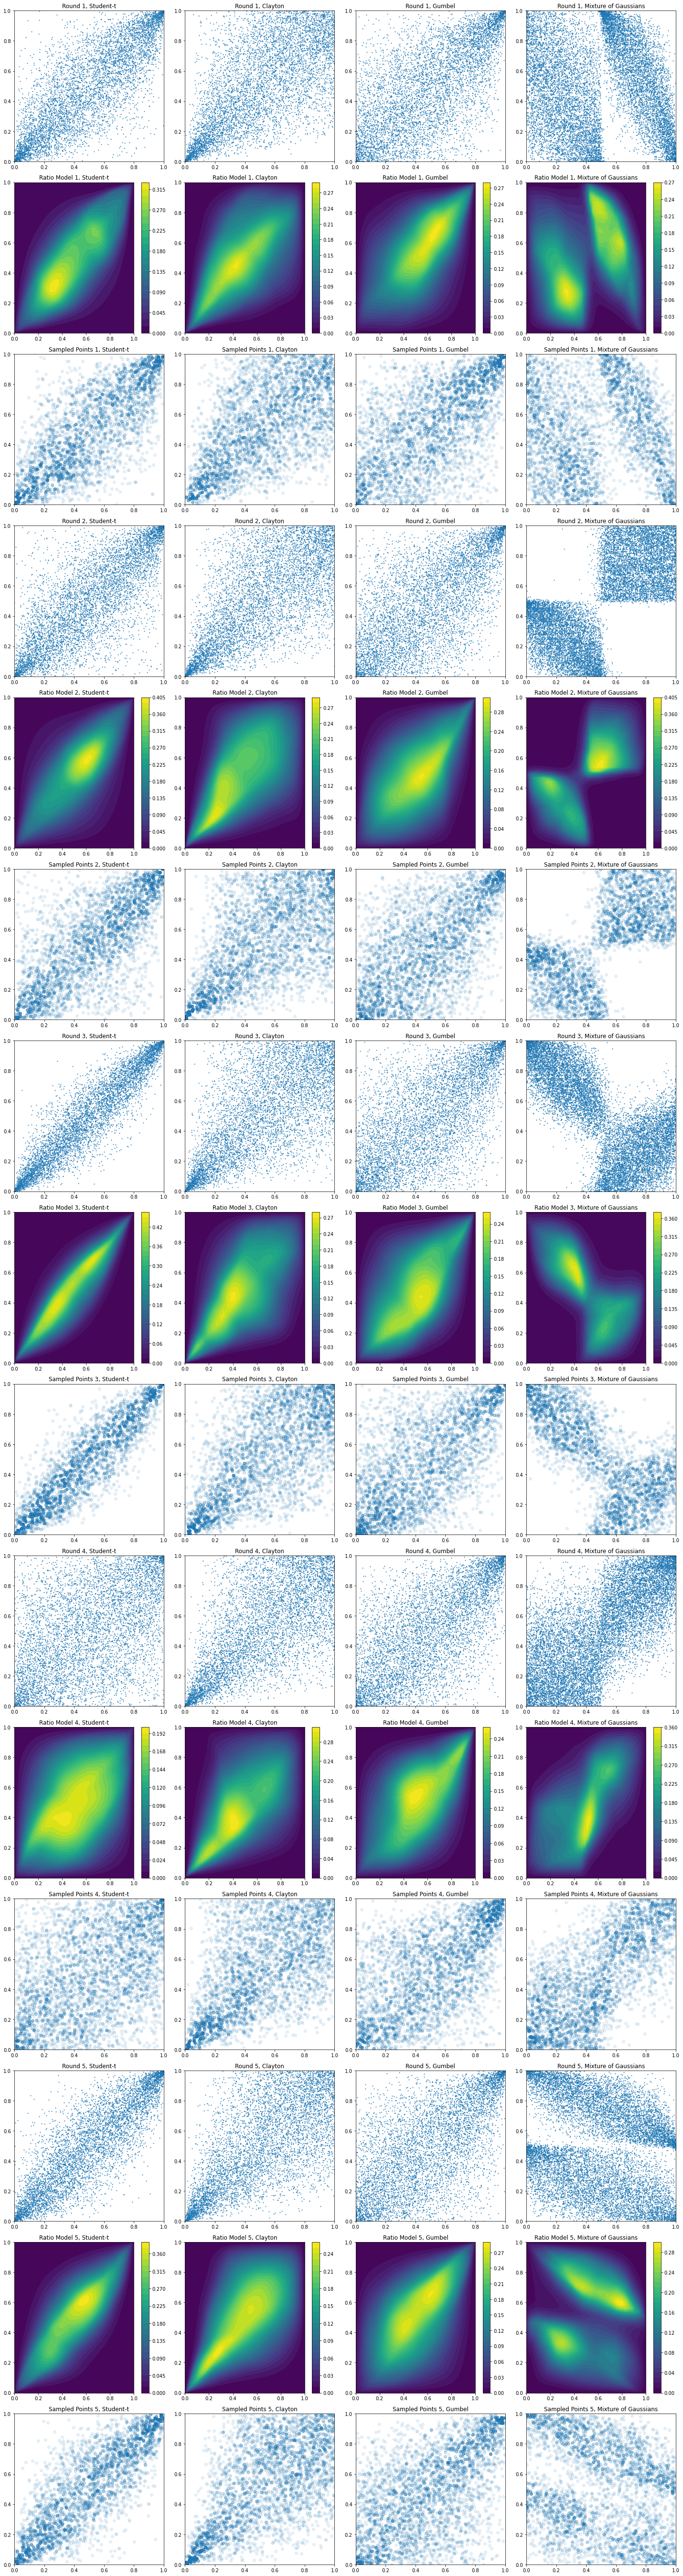

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats
from tqdm import tqdm
from scipy.special import logsumexp

def sample_ratio(ratio, n):
    '''
    Sample from the ratio copula with Sampling Importance Resampling.
    '''
    z = np.random.randn(n, 2)
    r_log = np.log(ratio(torch.tensor(z).float()).detach().numpy())
    sims = np.random.choice(np.arange(n), size=n, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
    return scipy.stats.norm.cdf(z[sims])

fig, axes = plt.subplots(int(75/5), 4, figsize=(20, int(375/5)))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

# Plot the true samples, the ratio models, and the sampled points
for i in range(5):
    for j in range(4):
        # Plot the true samples
        ax_true = axes[i * 12 + j]
        u1, u2 = sims_runs_all[i][j]
        ax_true.scatter(u1, u2, s=1)
        ax_true.set_xlim(0, 1)
        ax_true.set_ylim(0, 1)
        ax_true.set_title(f'Round {i+1}, {sample_types[j]}')

        # Plot the ratio models
        ax_ratio = axes[i * 12 + 4 + j]
        
        # Create a grid for plotting
        x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
        z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
        gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

        # Get the ratio
        r = ratios[i * 4 + j](z.float()).detach().numpy()
        Z = (r.reshape(100, 100)) * gauss
        contour = ax_ratio.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
        ax_ratio.set_xlim(0, 1)
        ax_ratio.set_ylim(0, 1)
        ax_ratio.set_title(f'Ratio Model {i+1}, {sample_types[j]}')
        fig.colorbar(contour, ax=ax_ratio)
        
        # Plot the sampled points
        ax_sampled = axes[i * 12 + 8 + j]
        samples_test = sample_ratio(ratios[i * 4 + j], 5000)
        ax_sampled.scatter(samples_test[:, 0], samples_test[:, 1], alpha=0.1)
        ax_sampled.set_xlim(0, 1)
        ax_sampled.set_ylim(0, 1)
        ax_sampled.set_title(f'Sampled Points {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

In [29]:
import scipy

# HMC sampling from the ratio copula
from pyhmc import hmc
def sample_ratio(ratio_model, n,hmc_runs=5,burn_in_n=1000,bimodal_hmc=False):
    def log_r_times_gauss(x):
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        fun = torch.log(ratio_model(x_tensor))+torch.distributions.Normal(0,1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad
        return np.array(fun.item(),dtype=np.float64), np.array(grad_wrt_x.detach().numpy(),dtype=np.float64)

    def sample_ratio_IS(ratio, n_prop, n_out):
        '''
        Sample from the ratio copula with Sampling Importance Resampling.
        '''
        z = np.random.randn(n_prop, 2)
        r_log = np.log(ratio(torch.tensor(z).float()).detach().numpy())+torch.distributions.Normal(0,1).log_prob(torch.tensor(z).float()).sum(1).detach().numpy().reshape(-1,1)
        sims = np.random.choice(np.arange(n_prop), size=n_out, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
        return scipy.stats.norm.cdf(z[sims])

    samples = []
    log_pdf_samples = []
    for hmc_run in range(hmc_runs): # multiple runs to avoid local modes
        # pcik a starting point with IS to be closer to equilibrium, so shorter burn_in
        start_x = sample_ratio_IS(ratio_model, 100, 1)
        if bimodal_hmc: # run HMC from both sides of the mode via reflection of x_0
            samples1 = hmc(log_r_times_gauss,
                        x0=start_x[0],
                        n_samples=int(n/2),
                        return_logp= True,
                        n_burn = burn_in_n)
            samples2 = hmc(log_r_times_gauss,
                    x0=-start_x[0],
                    n_samples=int(n/2),
                    return_logp= True,
                    n_burn = burn_in_n)
            samples.append(np.concatenate([samples1[0],samples2[0]]))
            log_pdf_samples.append(np.concatenate([samples1[1],samples2[1]]))
        else: 
            samples1 = hmc(log_r_times_gauss,
                        x0=start_x[0],
                        n_samples=n,
                        return_logp= True,
                        n_burn = burn_in_n)
            samples.append(samples1[0])
            log_pdf_samples.append(samples1[1])

        print('run',hmc_run,'DONE')
    # combine all runs
    samples = np.concatenate(samples)
    log_pdf_samples = np.concatenate(log_pdf_samples)
    return samples, log_pdf_samples

n_runs = 100
n_sims = 100
samples, log_pdf_samples = sample_ratio(ratios[16], n_sims, hmc_runs=n_runs, burn_in_n=10,bimodal_hmc=True)

run 0 DONE
run 1 DONE
run 2 DONE
run 3 DONE
run 4 DONE
run 5 DONE
run 6 DONE
run 7 DONE
run 8 DONE
run 9 DONE
run 10 DONE
run 11 DONE
run 12 DONE
run 13 DONE
run 14 DONE
run 15 DONE
run 16 DONE
run 17 DONE
run 18 DONE
run 19 DONE
run 20 DONE
run 21 DONE
run 22 DONE
run 23 DONE
run 24 DONE
run 25 DONE
run 26 DONE
run 27 DONE
run 28 DONE
run 29 DONE
run 30 DONE
run 31 DONE
run 32 DONE
run 33 DONE
run 34 DONE
run 35 DONE
run 36 DONE
run 37 DONE
run 38 DONE
run 39 DONE
run 40 DONE
run 41 DONE
run 42 DONE
run 43 DONE
run 44 DONE
run 45 DONE
run 46 DONE
run 47 DONE
run 48 DONE
run 49 DONE
run 50 DONE
run 51 DONE
run 52 DONE
run 53 DONE
run 54 DONE
run 55 DONE
run 56 DONE
run 57 DONE
run 58 DONE
run 59 DONE
run 60 DONE
run 61 DONE
run 62 DONE
run 63 DONE
run 64 DONE
run 65 DONE
run 66 DONE
run 67 DONE
run 68 DONE
run 69 DONE
run 70 DONE
run 71 DONE
run 72 DONE
run 73 DONE
run 74 DONE
run 75 DONE
run 76 DONE
run 77 DONE
run 78 DONE
run 79 DONE
run 80 DONE
run 81 DONE
run 82 DONE
run 83 DONE
ru

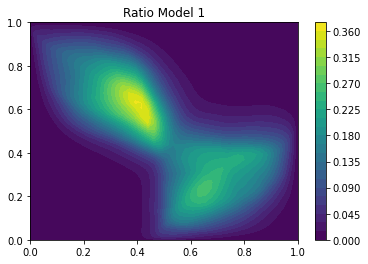

In [85]:
# contourf of ratios[0]

x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Get the ratio
r = ratios[11](z.float()).detach().numpy()
Z = (r.reshape(100, 100)) * gauss
plt.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Ratio Model 1')  
plt.colorbar()
plt.show()

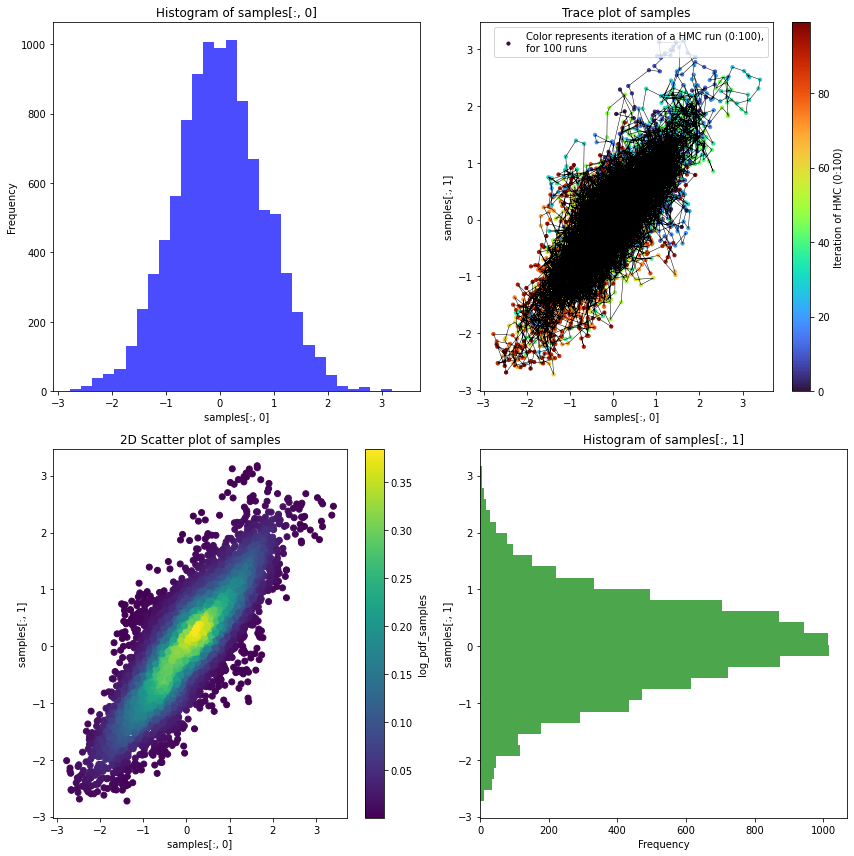

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Subplot [0,0]: Histogram of samples[:, 0]
axs[0, 0].hist(samples[:, 0], bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Histogram of samples[:, 0]')
axs[0, 0].set_xlabel('samples[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal')
axs[1, 1].set_title('Histogram of samples[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples[:, 0], samples[:, 1], c=np.exp(log_pdf_samples), cmap='viridis', marker='o')
axs[1, 0].set_title('2D Scatter plot of samples')
axs[1, 0].set_xlabel('samples[:, 0]')
axs[1, 0].set_ylabel('samples[:, 1]')
fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples
color_array = np.tile(np.arange(n_sims), n_runs)
sc_ = axs[0, 1].scatter(samples[:, 0], samples[:, 1], c=color_array, cmap='turbo', s=10)  # Set size of points
axs[0, 1].scatter(samples[:, 0], samples[:, 1], c=color_array, cmap='turbo', alpha=0.1, s=10)  # Set size of points
axs[0, 1].plot(samples[:, 0], samples[:, 1], color='black', linewidth=0.5)
axs[0, 1].set_title('Trace plot of samples')
axs[0, 1].set_xlabel('samples[:, 0]')
axs[0, 1].set_ylabel('samples[:, 1]')
fig.colorbar(sc_, ax=axs[0, 1], label=f'Iteration of HMC (0:{n_sims})')
legend_label = f'Color represents iteration of a HMC run (0:{n_sims}),\nfor {n_runs} runs'
axs[0, 1].legend([legend_label], loc='upper right')


plt.tight_layout()
plt.show()

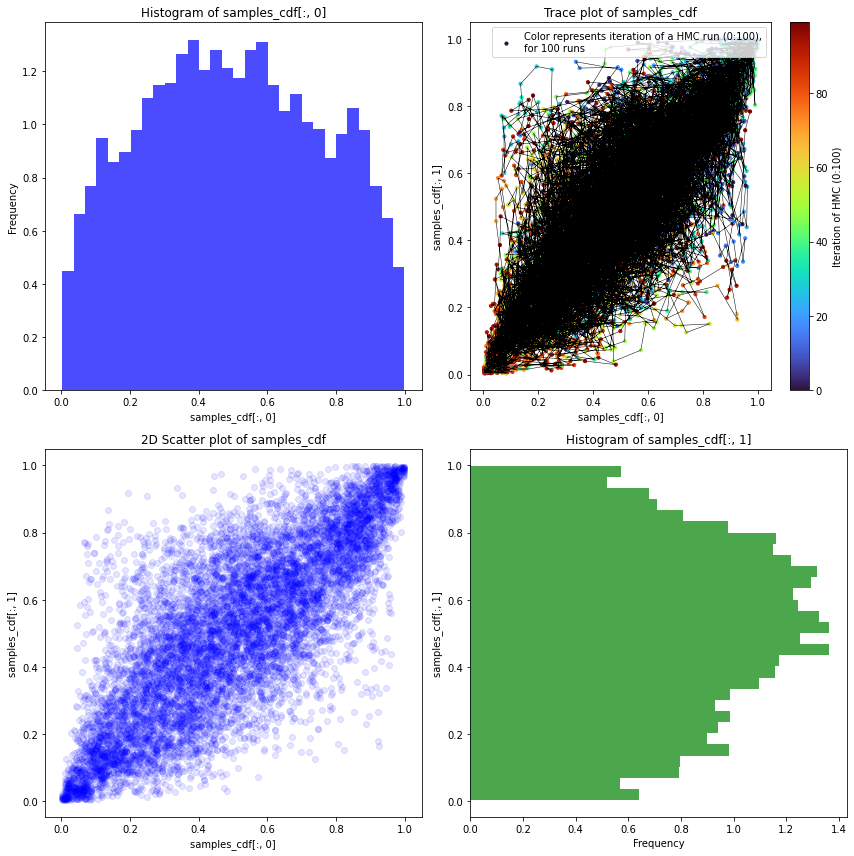

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

# Transform samples using the CDF
samples_cdf = scs.norm.cdf(samples)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Subplot [0,0]: Histogram of samples_cdf[:, 0]
axs[0, 0].hist(samples_cdf[:, 0], bins=30, color='blue', alpha=0.7,density=True)
axs[0, 0].set_title('Histogram of samples_cdf[:, 0]')
axs[0, 0].set_xlabel('samples_cdf[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples_cdf[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples_cdf[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal',density=True)
axs[1, 1].set_title('Histogram of samples_cdf[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples_cdf[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples_cdf with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c='blue',alpha=0.1, marker='o')
axs[1, 0].set_title('2D Scatter plot of samples_cdf')
axs[1, 0].set_xlabel('samples_cdf[:, 0]')
axs[1, 0].set_ylabel('samples_cdf[:, 1]')
#fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples_cdf
color_array = np.tile(np.arange(n_sims), n_runs)
sc_ = axs[0, 1].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c=color_array, cmap='turbo', s=10)  # Set size of points
axs[0, 1].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c=color_array, cmap='turbo', alpha=0.1, s=10)  # Set size of points
axs[0, 1].plot(samples_cdf[:, 0], samples_cdf[:, 1], color='black', linewidth=0.5)
axs[0, 1].set_title('Trace plot of samples_cdf')
axs[0, 1].set_xlabel('samples_cdf[:, 0]')
axs[0, 1].set_ylabel('samples_cdf[:, 1]')
fig.colorbar(sc_, ax=axs[0, 1], label=f'Iteration of HMC (0:{n_sims})')
legend_label = f'Color represents iteration of a HMC run (0:{n_sims}),\nfor {n_runs} runs'
axs[0, 1].legend([legend_label], loc='upper right')

plt.tight_layout()
plt.show()

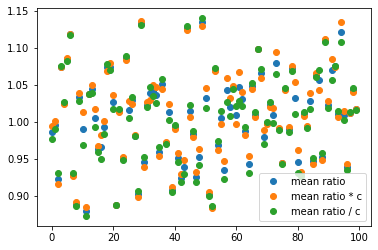

In [33]:
prop_scale = 1
r_idx = 6
out = []
for r_idx in range(len(ratios)):
    samples_gauss = torch.normal(mean=0., std=prop_scale, size=(10000, 2))
    r_gauss_1_2 = torch.distributions.Normal(loc=0., scale=1.).log_prob(samples_gauss).sum(1).detach().numpy()-torch.distributions.Normal(loc=0., scale=prop_scale).log_prob(samples_gauss).sum(1).detach().numpy()
    r_gauss = ratios[r_idx](samples_gauss).detach().numpy()/np.exp(r_gauss_1_2) 
    out.append(   [ r_gauss.mean(),r_gauss.mean()*ratios[r_idx].c.item(),r_gauss.mean()/ratios[r_idx].c.item()])

plt.plot([out[i][0] for i in range(len(ratios))],'o',label='mean ratio')
plt.plot([out[i][1] for i in range(len(ratios))],'o',label='mean ratio * c')
plt.plot([out[i][2] for i in range(len(ratios))],'o',label='mean ratio / c')
plt.legend()

In [35]:
import numpy as np
import scipy.stats as scs
from scipy.integrate import simps
import torch

# Define the grid
x = np.linspace(1e-5, 1-1e-5, 500)
y = np.linspace(1e-5, 1-1e-5, 500)
X, Y = np.meshgrid(x, y)

# Evaluate the function over the grid
Z = np.zeros_like(X)
for i in tqdm(range(len(x))):
    for j in range(len(y)):
        x_ = scs.norm.ppf(X[i, j])
        y_ = scs.norm.ppf(Y[i, j])
        Z[i, j] = ratios[-1](torch.tensor([x_, y_]).float()).detach().numpy()

# Integrate using Simpson's rule
integral = simps(simps(Z, y), x)

print(f"Integral result: {integral}")

100%|██████████| 500/500 [01:42<00:00,  4.89it/s]

Integral result: 1.0252814952110316


### sampling with AIS

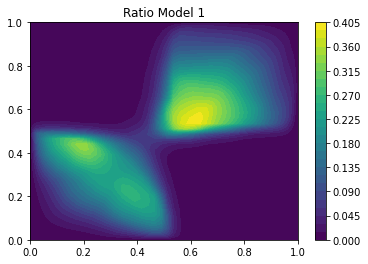

In [96]:
model_NB = 7

x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Get the ratio
r = ratios[model_NB](z.float()).detach().numpy()
Z = (r.reshape(100, 100)) * gauss
plt.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Ratio Model 1')  
plt.colorbar()
plt.show()

In [111]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import torch
import torch.nn as nn
from pyhmc import hmc  
from tqdm import tqdm

# Define the ratio_model in PyTorch
class RatioModel(nn.Module):
    '''
    Pytorch ratio model.

    Args:
        ratio_model: The basic ratio model in pytorch.
    
    forward:
        Compute the log of ratio*gauss, which is the sampling density of the copula.
        inputs: The input to the ratio model.
            can be any array - is converted to torch.tensor inside.

    Returns:
        The log of the ratio model, as a numpy array.
    '''
    def __init__(self, ratio_model):
        super(RatioModel, self).__init__()
        self.ratio_model = ratio_model

    def forward(self, inputs):
        log_pdf, grad_x = self.log_r_times_gauss(inputs)
        return log_pdf

    def log_r_times_gauss(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        fun = torch.log(self.ratio_model(x_tensor)) + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

ratio_model_instance = RatioModel(ratios[model_NB])

# Define the target log-density function
def target_log_prob_fn(x):
    # Convert TensorFlow tensor to NumPy array
    x_np = x
    # Compute log-density using the PyTorch model
    log_density = ratio_model_instance(x_np)
    # Convert the result to a TensorFlow tensor
    return tf.convert_to_tensor(log_density, dtype=tf.float32)

# Set up the AIS sampler
num_results = 500
num_burnin_steps = 100
num_steps = 10
inverse_temperatures = tf.linspace(0.0, 1.0, num_steps)

# Initial distribution: standard normal
initial_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1.5, 1.5])

# Run the AIS sampler
def run_ais():
    samples = []
    current_state = initial_distribution.sample(num_results).numpy()
    for beta in tqdm(inverse_temperatures):
        def tempered_log_prob_fn(x):
            x_tensor = torch.tensor(x, requires_grad=True, dtype=torch.float32)
            log_prob, grad = ratio_model_instance.log_r_times_gauss(x_tensor)
            log_prob = beta * log_prob + (1 - beta) * tf.reduce_sum(initial_distribution.log_prob(x_tensor.detach().numpy())).numpy().item()
            return log_prob, grad

        current_state = torch.tensor(current_state, dtype=torch.float32)
        samples1, _ = hmc(tempered_log_prob_fn,  # Use the tempered log prob function here
                          x0=current_state[0],
                          n_samples=int(num_results/2),
                          return_logp=True,
                          n_burn=num_burnin_steps)
        current_state = samples1
        samples.append(current_state)

    return tf.convert_to_tensor(np.concatenate(samples, axis=0), dtype=tf.float32)

samples = run_ais()

# Convert samples to NumPy array
samples_np_tf = samples.numpy()

# Print the shape of the samples
print(f"Shape of the samples: {samples_np_tf.shape}")


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_27340\3981766188.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
100%|██████████| 10/10 [02:01<00:00, 12.16s/it]

Shape of the samples: (2500, 2)


In [112]:
import torch
import torch.nn as nn
import torch.distributions as dist
import numpy as np
from pyhmc import hmc
from tqdm import tqdm

# Define the ratio_model in PyTorch
class RatioModel(nn.Module):
    '''
    Pytorch ratio model.

    Args:
        ratio_model: The basic ratio model in pytorch.
    
    forward:
        Compute the log of ratio*gauss, which is the sampling density of the copula.
        inputs: The input to the ratio model.
            can be any array - is converted to torch.tensor inside.

    Returns:
        The log of the ratio model, as a numpy array.
    '''
    def __init__(self, ratio_model):
        super(RatioModel, self).__init__()
        self.ratio_model = ratio_model

    def forward(self, inputs):
        log_pdf, grad_x = self.log_r_times_gauss(inputs)
        return log_pdf

    def log_r_times_gauss(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        fun = torch.log(self.ratio_model(x_tensor)) + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

# Define the target log-density function
def target_log_prob_fn(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    log_density = ratio_model_instance(x_tensor)
    return log_density

# Annealed Importance Sampling
def ais(num_samples, num_steps, initial_distribution, burn_steps):
    samples = initial_distribution.sample((num_samples,))
    inverse_temperatures = torch.linspace(0.0, 1.0, num_steps)

    for beta in tqdm(inverse_temperatures):
        def tempered_log_prob_fn(x):
            x_tensor = torch.tensor(x, requires_grad=True, dtype=torch.float32)
            log_prob, grad = ratio_model_instance.log_r_times_gauss(x_tensor)
            log_prob = beta * log_prob + (1 - beta) * initial_distribution.log_prob(x_tensor).sum().item()
            return log_prob, grad

        for i in range(num_samples):
            sample_np, _ = hmc(tempered_log_prob_fn,  # Use the tempered log prob function here
                               x0=samples[i].numpy(),
                               n_samples=1,
                               return_logp=True,
                               n_burn=burn_steps)
            samples[i] = torch.tensor(sample_np, dtype=torch.float32)

    return samples

# Example usage
ratio_model_instance = RatioModel(ratio_model=ratios[model_NB])  # Replace `your_ratio_model` with your actual model
initial_distribution = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
num_samples = 500
num_steps = 10
num_burn = 100

samples = ais(num_samples, num_steps, initial_distribution, num_burn)
samples_np_torch = samples.numpy()

print(f"Shape of the samples: {samples_np_torch.shape}")

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_27340\3387605066.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
100%|██████████| 10/10 [18:41<00:00, 112.13s/it]

Shape of the samples: (500, 2)


In [107]:
samples_hmc, log_pdf_samples_hmc = sample_ratio(ratios[model_NB], n=500, hmc_runs=4, burn_in_n=10,bimodal_hmc=True)

run 0 DONE
run 1 DONE
run 2 DONE
run 3 DONE


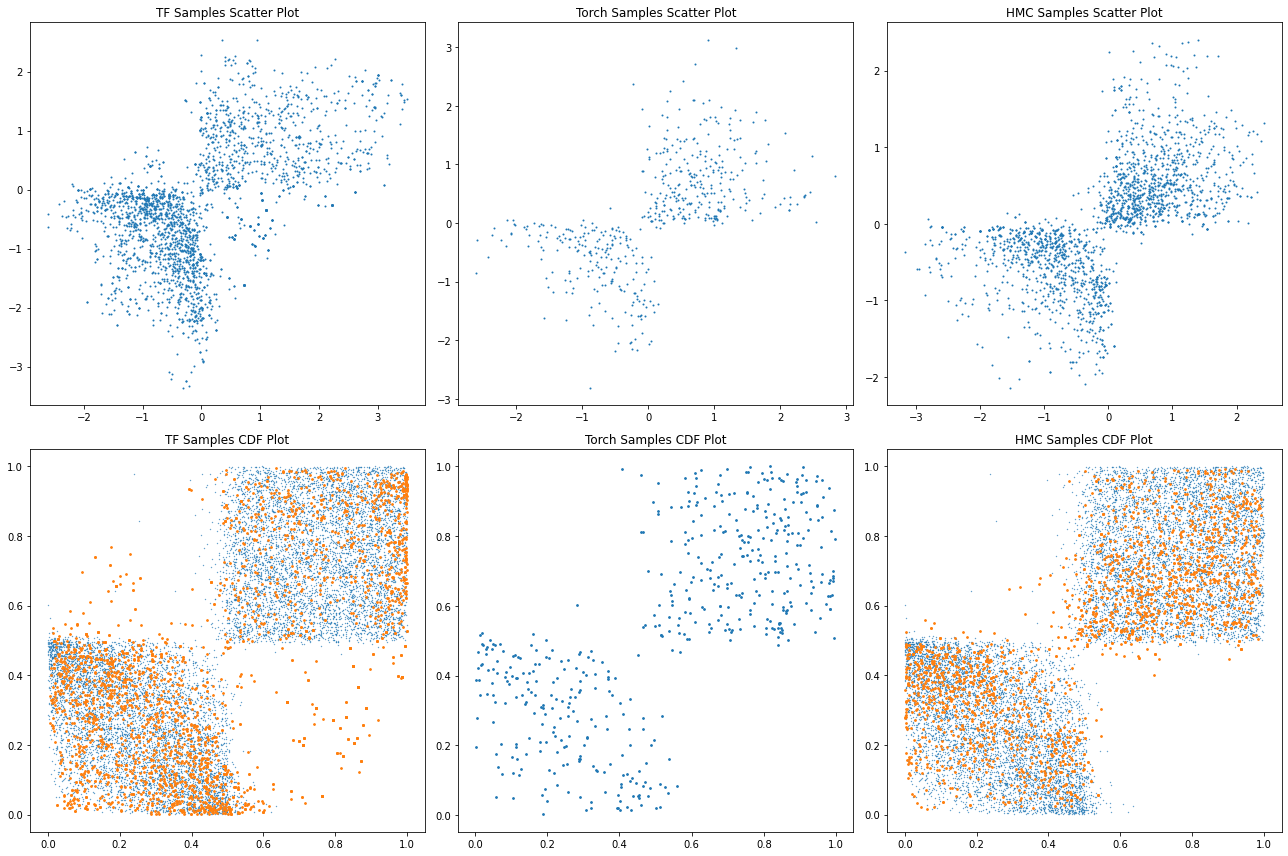

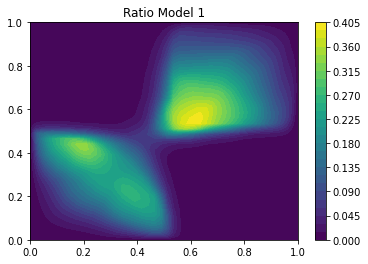

In [115]:
# plot the difference between the three samples
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# First row: scatter plots
axs[0, 0].scatter(samples_np_tf[:, 0], samples_np_tf[:, 1], s=1)
axs[0, 0].set_title('TF Samples Scatter Plot')

axs[0, 1].scatter(samples_np_torch[:, 0], samples_np_torch[:, 1], s=1)
axs[0, 1].set_title('Torch Samples Scatter Plot')

axs[0, 2].scatter(samples_hmc[:, 0], samples_hmc[:, 1], s=1)
axs[0, 2].set_title('HMC Samples Scatter Plot')

# Second row: CDF plots
u1, u2 = sims_runs_all[model_NB//4][model_NB%4]
axs[1, 0].scatter(u1, u2, s=0.1)
axs[1, 0].scatter(scs.norm.cdf(samples_np_tf[:, 0]), scs.norm.cdf(samples_np_tf[:, 1]), s=3)
axs[1, 0].set_title('TF Samples CDF Plot')

#axs[1, 1].scatter(u1, u2, s=0.1)
axs[1, 1].scatter(scs.norm.cdf(samples_np_torch[:, 0]), scs.norm.cdf(samples_np_torch[:, 1]), s=3)
axs[1, 1].set_title('Torch Samples CDF Plot')

axs[1, 2].scatter(u1, u2, s=0.1)
axs[1, 2].scatter(scs.norm.cdf(samples_hmc[:, 0]), scs.norm.cdf(samples_hmc[:, 1]), s=3)
axs[1, 2].set_title('HMC Samples CDF Plot')

plt.tight_layout()
plt.show()

# Plot the ratio model
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scs.norm.pdf(x) * scs.norm.pdf(y)

# Get the ratio
r = ratios[7](z.float()).detach().numpy()
Z = (r.reshape(100, 100)) * gauss
plt.contourf(scs.norm.cdf(x), scs.norm.cdf(y), Z, levels=30)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Ratio Model 1')  
plt.colorbar()
plt.show()

### Logistic classifier

In [319]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

class QuadraticNNHead(nn.Module):
    ''' 
    Quadratic neural network head model. Used inside W_Ratio model to
    map from (n,input_dim) of the hidden body to the (n,1) output.
    '''
    def __init__(self, input_dim):
        super(QuadraticNNHead, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.interaction_terms = nn.Parameter(0.001*torch.randn(input_dim, input_dim))

    def forward(self, x):
        linear_output = self.linear(x)
        interaction_output = torch.matmul(x.unsqueeze(2), x.unsqueeze(1))  # Shape: (batch_size, num_features, num_features)
        interaction_output = interaction_output * self.interaction_terms  # Element-wise multiplication
        interaction_output = interaction_output.sum()  # Sum over the feature dimensions
        output = linear_output + interaction_output
        return output



class W_Ratio(nn.Module):
    '''
    [W]aymark ratio copula model with a mixture of classifiers. 
    The mixing classifiers share the same hidden architecture but have different heads.
    Each mixture classifier is applied to a waymark dataset interpolating D_p and D_q.

    Args:
        h_dim (int): hidden dimension
        in_dim (int): input dimension
        h_layers (int): number of hidden layers
        w_num (int): number of classifiers in the mixture
    '''
    def __init__(self, h_dim=100, in_dim=2, h_layers=2, w_num=2, normalising_cst = False, c = 1.0):
        super(W_Ratio, self).__init__()

        self.h_dim = h_dim
        self.in_dim = in_dim
        self.h_layers = h_layers
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))
        self.fc_in = nn.Linear(self.in_dim, self.h_dim)
        self.fc_hidden = nn.Linear(self.h_dim, self.h_dim)
        if w_num <2:
            raise ValueError('Number of waymark classifiers should be at least 2')
        self.w_num = w_num
        # Linear heads for each mixture classifier
        self.linear_heads = nn.ModuleList([nn.Linear(self.h_dim, 1) for _ in range(w_num)])
        # Quadratic heads for each mixture classifier
        self.quadratic_heads = nn.ModuleList([QuadraticNNHead(self.h_dim) for _ in range(w_num)]) 

    def waymark(self, data_p, data_q, alpha):
        return torch.sqrt(1 - alpha) * data_p + torch.sqrt(alpha) * data_q
        
    def hidden_body(self, x):
        x = F.relu(self.fc_in(x))
        for _ in range(self.h_layers):
            x = F.relu(self.fc_hidden(x)) + x
        return x
    
    def forward(self, x):
        out_ratio = []
        # common body pass
        x_waymark = self.hidden_body(x)
        for waymark in range(self.w_num):
            # Forward head pass
            out_ratio.append(self.quadratic_heads[waymark](x_waymark))
        out_ratio = torch.stack(out_ratio, dim=0)
        out_ratio = torch.logsumexp(out_ratio, dim=0) # numerically stable
        return out_ratio.exp()
    
    def forward_waymark(self, x, w_idx):
        # common body pass
        x_waymark = self.hidden_body(x)
        # Forward head pass
        #out_ratio = self.quadratic_heads[w_idx](x_waymark)
        out_ratio = self.linear_heads[w_idx](x_waymark)
        return out_ratio.exp()

# Define the ratio model
ratio_model = W_Ratio(h_dim=100, in_dim=2, h_layers=2, w_num=2)
#ratio_model(torch.randn(20, 2))
ratio_model.forward_waymark(torch.randn(20, 2), 0)


tensor([[0.9793],
        [0.9849],
        [1.1155],
        [1.1215],
        [0.9450],
        [0.8957],
        [1.0224],
        [0.8388],
        [0.9896],
        [1.1418],
        [1.1002],
        [0.8122],
        [1.0780],
        [1.0525],
        [1.0747],
        [1.0959],
        [0.7765],
        [0.7144],
        [0.8830],
        [0.7492]], grad_fn=<ExpBackward0>)

In [321]:
ratios_WAYMARK = []
W_NUM = 2

for r,run in tqdm(enumerate(sims_runs_all[:2])):
    # run = [u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]
    for u,u1_u2 in enumerate(run):
        # u1_u2 = [u1, u2]
        z1,z2 = scs.norm.ppf(u1_u2[0][:N_TRAIN]),scs.norm.ppf(u1_u2[1][:N_TRAIN])
        p_data = np.column_stack((z1,z2))
        p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
        q_data = np.random.randn(50000,2)
        ratio_logstc = W_Ratio(h_dim=50, in_dim=2, h_layers=2, w_num=W_NUM)
        for w in range(W_NUM):
            # Fit Logistic Ratio copula
            optimizer = torch.optim.Adam(ratio_logstc.parameters(), lr=0.0001)
            w_alpha = torch.linspace(0,1,W_NUM+1)
            
            for epoch in (range(101)):
                p_data_w = ratio_logstc.waymark(torch.tensor(p_data).float(),  torch.randn(p_data.shape).float(), w_alpha[w])
                q_data_w = ratio_logstc.waymark(torch.tensor(p_data).float(), torch.randn(p_data.shape).float(), w_alpha[w+1])
                optimizer.zero_grad()
                r_p = ratio_logstc(torch.tensor(p_data_w).float())
                r_q = ratio_logstc(torch.tensor(q_data_w).float())
                #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
                loss = loss_nce(r_p, r_q, p_data.shape[0], q_data.shape[0])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(ratio_logstc.parameters(), 1.)
                optimizer.step()
                if epoch % 100 == 0 and epoch > 0:
                    with torch.no_grad():
                        if ratio_logstc.normalising_cst:#epoch==500:# check the value and gradient of the normalising constant
                            print(f'Epoch {epoch}, normalising constant {ratio_logstc.c.item()}', ratio_logstc.c.grad.item())
                        #check if loss is not a number
                        if torch.isnan(loss):
                            print(r,u,'NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                        #print(f'Epoch {epoch}, loss {loss.item()}')
        print('run',r,'cop_u',u,'DONE')
        ratios_WAYMARK.append(ratio_logstc)


0it [00:00, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_27340\1984398003.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_p = ratio_logstc(torch.tensor(p_data_w).float())
C:\Users\david\AppData\Local\Temp\ipykernel_27340\1984398003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_q = ratio_logstc(torch.tensor(q_data_w).float())


0 0 NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
run 0 cop_u 0 DONE


0it [00:17, ?it/s]


KeyboardInterrupt: 

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


IndexError: list index out of range

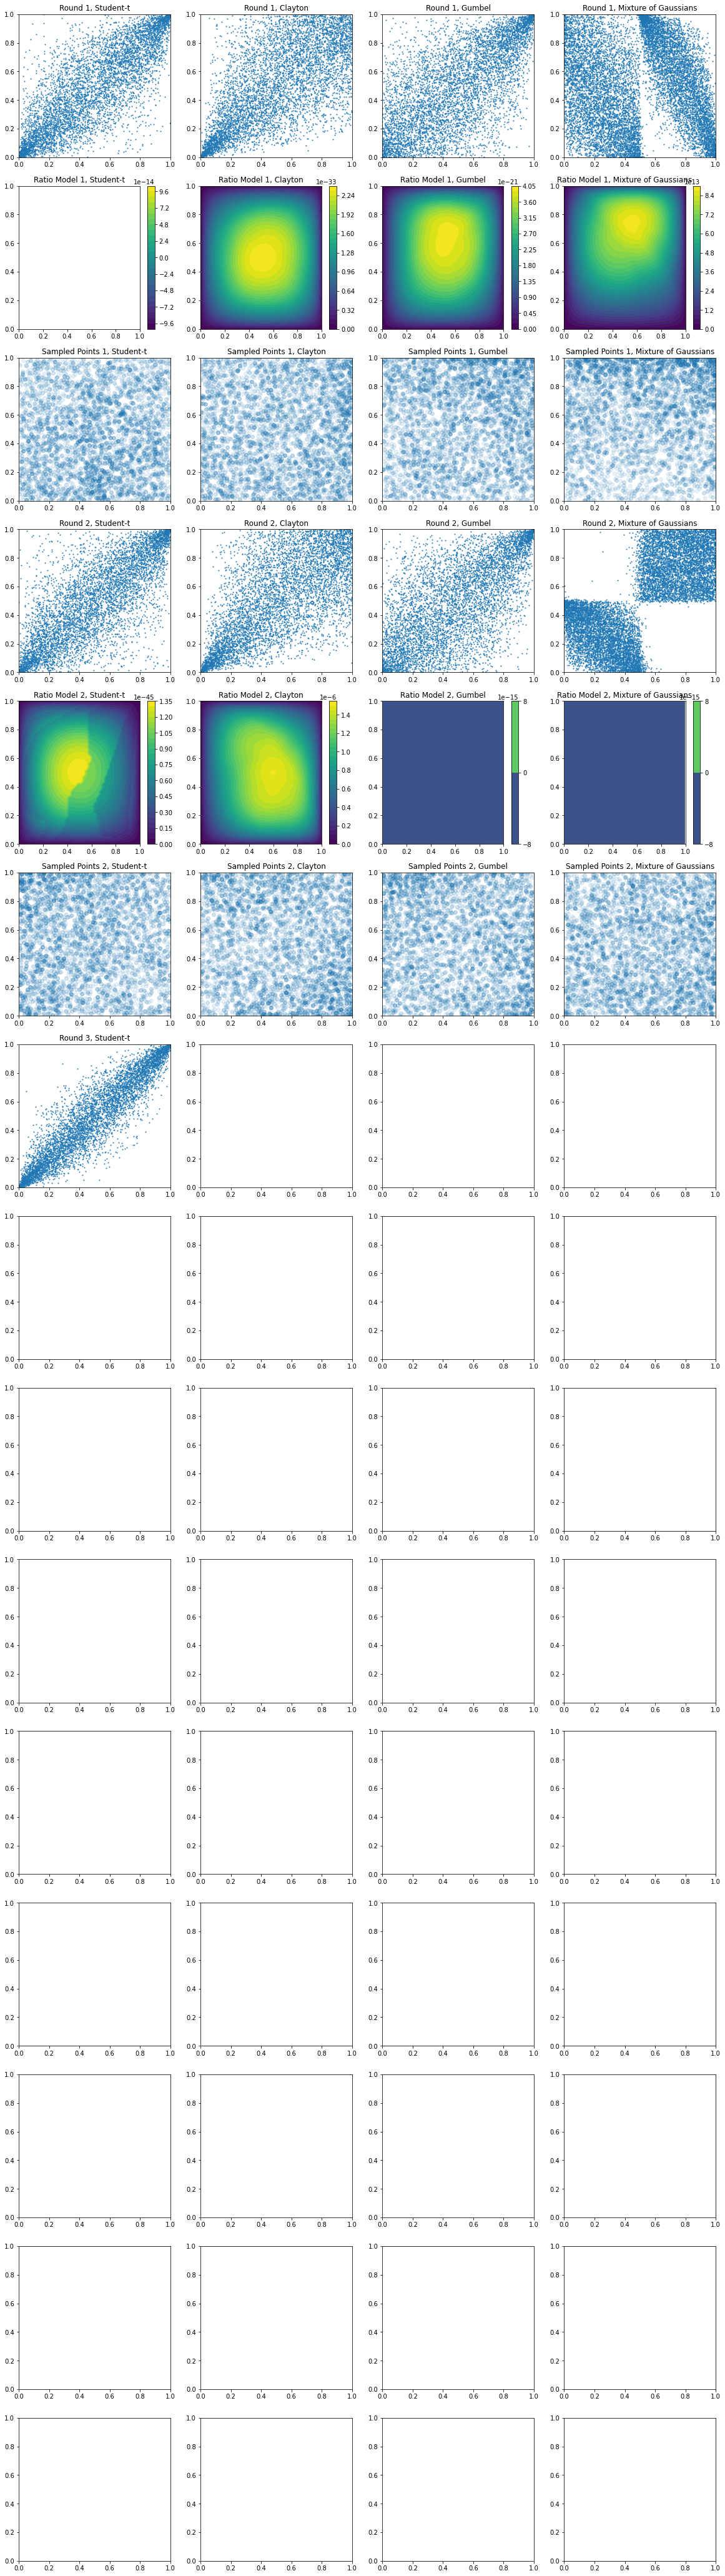

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats
from tqdm import tqdm
from scipy.special import logsumexp

def sample_ratio(ratio, n):
    '''
    Sample from the ratio copula with Sampling Importance Resampling.
    '''
    z = np.random.randn(n, 2)
    r_log = np.log(ratio(torch.tensor(z).float()).detach().numpy())
    sims = np.random.choice(np.arange(n), size=n, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
    return scipy.stats.norm.cdf(z[sims])

fig, axes = plt.subplots(int(75/5), 4, figsize=(20, int(375/5)))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

# Plot the true samples, the ratio models, and the sampled points
for i in range(5):
    for j in range(4):
        # Plot the true samples
        ax_true = axes[i * 12 + j]
        u1, u2 = sims_runs_all[i][j]
        ax_true.scatter(u1, u2, s=1)
        ax_true.set_xlim(0, 1)
        ax_true.set_ylim(0, 1)
        ax_true.set_title(f'Round {i+1}, {sample_types[j]}')

        # Plot the ratio models
        ax_ratio = axes[i * 12 + 4 + j]
        
        # Create a grid for plotting
        x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
        z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
        gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

        # Get the ratio
        r = ratios_WAYMARK[i * 4 + j](z.float()).detach().numpy()
        Z = (r.reshape(100, 100)) * gauss
        contour = ax_ratio.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
        ax_ratio.set_xlim(0, 1)
        ax_ratio.set_ylim(0, 1)
        ax_ratio.set_title(f'Ratio Model {i+1}, {sample_types[j]}')
        fig.colorbar(contour, ax=ax_ratio)
        
        # Plot the sampled points
        ax_sampled = axes[i * 12 + 8 + j]
        samples_test = sample_ratio(ratios_WAYMARK[i * 4 + j], 5000)
        ax_sampled.scatter(samples_test[:, 0], samples_test[:, 1], alpha=0.1)
        ax_sampled.set_xlim(0, 1)
        ax_sampled.set_ylim(0, 1)
        ax_sampled.set_title(f'Sampled Points {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()